In [ ]:
#!pip install pycocotools pytorch_lightning coco-eval --quiet
#!pip install pytorch_lightning
#!pip install -q coco-eval
#!pip install --upgrade torch torchvision

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from zipfile import ZipFile
import os
import json
from collections import defaultdict
from PIL import Image, ImageDraw
import torch
import torchvision
import pytorch_lightning as pl
from pytorch_lightning import Trainer
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from torch.utils.data import DataLoader
from transformers import DetrImageProcessor
from transformers import DetrForObjectDetection
from coco_eval import CocoEvaluator
from pycocotools.coco import COCO as coco
from tqdm.notebook import tqdm

In [ ]:
# importing the zipfile module
os.chdir('/home/sasturkar.h/')
# loading the temp.zip and creating a zip object
with ZipFile("trash.v33.zip", 'r') as zObject:

    # Extracting all the members of the zip
    # into a specific location.
    zObject.extractall( path= "trash_data" )

## Prepare datasets

In [ ]:
# Class for reforming datasets into coco detection format
class CocoDetection(torchvision.datasets.CocoDetection):
    def __init__(self, img_folder, processor, train=False, train_annot = None, val= False, test = False):
        if train:
            ann_file = os.path.join(img_folder, train_annot)
        elif val:
            ann_file = os.path.join(img_folder, "val_annot.json")
        elif test:
            ann_file = os.path.join(img_folder, "test_annot.json")
        super(CocoDetection, self).__init__(img_folder, ann_file)
        self.processor = processor

    def __getitem__(self, idx):
        # read in PIL image and target in COCO format
        # feel free to add data augmentation here before passing them to the next step
        img, target = super(CocoDetection, self).__getitem__(idx)

        # preprocess image and target (converting target to DETR format, resizing + normalization of both image and target)
        image_id = self.ids[idx]
        target = {'image_id': image_id, 'annotations': target}
        encoding = self.processor(images=img, annotations=target, return_tensors="pt")
        pixel_values = encoding["pixel_values"].squeeze() # remove batch dimension
        target = encoding["labels"][0] # remove batch dimension

        return pixel_values, target


In [ ]:
# processor = DetrImageProcessor.from_pretrained("facebook/detr-resnet-50")

# train = CocoDetection(img_folder='trash_data/trash.v33-allclass.coco.zip (Unzipped Files)/train', processor=processor, train=True, train_annot="_annotations.coco.json")

loading annotations into memory...
Done (t=0.96s)
creating index...
index created!


In [ ]:
# Split images into train and validation per category
def split_data(imgs_path):

    # Initialize dictionaries for each split
    train_dict={}
    val_dict={}

    # Copy category information to all splits
    train_dict['categories'], val_dict['categories'] = list(train.coco.cats.values()), list(train.coco.cats.values())

    # Initialize image and annotation lists for each split
    train_dict['images'], train_dict['annotations'] = [], []
    val_dict['images'], val_dict['annotations'] = [], []

    for category_id in train.coco.getCatIds():
        number_of_imgs = len(train.coco.getImgIds(catIds=[category_id]))
        number_val_imgs = int(np.floor(number_of_imgs * 0.2)) # 20% of images go into validation with 80% in train
        # Randomly shuffle image order
        random_list_val = np.random.choice(train.coco.getImgIds(catIds=[category_id]), size=number_val_imgs, replace=False)
        random_list = np.random.choice(train.coco.getImgIds(catIds=[category_id]), size=number_of_imgs, replace=False)

        # Iterate through images and assign to splits based on random order

        for idx, img_id in enumerate(random_list):
            try:
                # Check if image has annotations
                if len(train.coco.imgToAnns[img_id]) > 0:

                    # Assign image and annotations based on index position
                    if img_id in random_list_val:
                        val_dict['images'].append(train.coco.loadImgs(int(img_id))[0])
                        val_dict['annotations'].append(train.coco.imgToAnns[img_id])

                    else:
                        train_dict['images'].append(train.coco.loadImgs(int(img_id))[0])
                        train_dict['annotations'].append(train.coco.imgToAnns[img_id])

            except Exception as e:
                print(f"Error processing image {img_id}: {e}")
                continue

    # Flatten annotation lists
    train_dict['annotations'] = [item for sublist in train_dict['annotations'] for item in sublist]
    val_dict['annotations'] = [item for sublist in val_dict['annotations'] for item in sublist]

    # Print final split information
    print(f"""
    Train annotations: {len(train_dict['annotations'])}
    Validation annotations: {len(val_dict['annotations'])}
    Train images: {len(train_dict['images'])}
    Validation images: {len(val_dict['images'])}
    """)

    return train_dict, val_dict

In [ ]:
 train_dict, val_dict = split_data("trash_data/trash.v33-allclass.coco.zip (Unzipped Files)/train")


    Train annotations: 31628
    Validation annotations: 7502
    Train images: 11155
    Validation images: 2781
    


In [ ]:
# Create JSON annotation files for each dataset
train_annot = json.dumps(train_dict)
val_annot = json.dumps(val_dict)

file_path_train = 'trash_data/trash.v33-allclass.coco.zip (Unzipped Files)/train/train_annot.json'
file_path_val = 'trash_data/trash.v33-allclass.coco.zip (Unzipped Files)/train/val_annot.json'

# Save JSON data to file
with open(file_path_train, 'w') as json_file:
    json_file.write(train_annot)

with open(file_path_val, 'w') as json_file:
    json_file.write(val_annot)

In [ ]:
# Load data
processor = DetrImageProcessor.from_pretrained("facebook/detr-resnet-50")

train = CocoDetection(img_folder='trash_data/trash.v33-allclass.coco.zip (Unzipped Files)/train', processor=processor, train=True, train_annot="train_annot.json")
val = CocoDetection(img_folder='trash_data/trash.v33-allclass.coco.zip (Unzipped Files)/train', processor=processor, val=True)
test = CocoDetection(img_folder='trash_data/trash.v33-allclass.coco.zip (Unzipped Files)/valid', processor=processor, test=True)

loading annotations into memory...
Done (t=1.74s)
creating index...
index created!
loading annotations into memory...
Done (t=0.04s)
creating index...
index created!
loading annotations into memory...
Done (t=0.10s)
creating index...
index created!


In [ ]:
print("Number of training examples:", len(train))
print("Number of validation examples:", len(val))
print("Number of test examples:", len(test))

Number of training examples: 12813
Number of validation examples: 1044
Number of test examples: 2750


Image n°4771


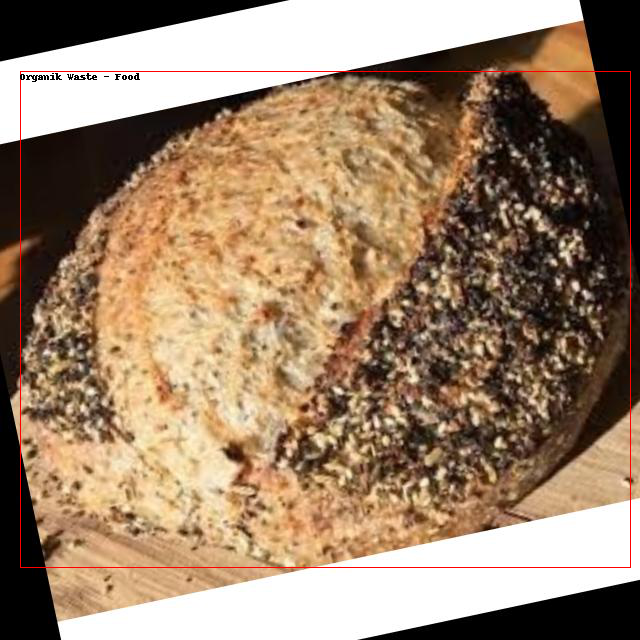

In [ ]:
# Visualizing images
image_ids = train.coco.getImgIds()
# let's pick a random image
image_id = image_ids[np.random.randint(0, len(image_ids))]
print('Image n°{}'.format(image_id))
image = train.coco.loadImgs(image_id)[0]
image = Image.open(os.path.join('trash_data/trash.v33-allclass.coco.zip (Unzipped Files)/train', image['file_name']))

annotations = train.coco.imgToAnns[image_id]
draw = ImageDraw.Draw(image, "RGBA")

cats = train.coco.cats
id2label = {k: v['name'] for k,v in cats.items()}

for annotation in annotations:
    box = annotation['bbox']
    class_idx = annotation['category_id']
    x,y,w,h = tuple(box)
    draw.rectangle((x,y,x+w,y+h), outline='red', width=1)
    draw.text((x, y), id2label[class_idx], fill='black')

image

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [ ]:
# Create Dataloaders
def collate_fn(batch):
    #print(batch)
    pixel_values = [item[0] for item in batch]
    encoding = processor.pad(pixel_values, return_tensors="pt")
    labels = [item[1] for item in batch]
    batch = {}
    batch['pixel_values'] = encoding['pixel_values']
    batch['pixel_mask'] = encoding['pixel_mask']
    batch['labels'] = labels

    return batch

train_dataloader = DataLoader(train, collate_fn=collate_fn, batch_size=4, shuffle=True, pin_memory=True, num_workers=3)
val_dataloader = DataLoader(val, collate_fn=collate_fn, batch_size=2, num_workers=3)
test_dataloader = DataLoader(test, collate_fn=collate_fn, batch_size=2, num_workers=3)

In [ ]:
batch = next(iter(train_dataloader))

In [ ]:
batch.keys()

dict_keys(['pixel_values', 'pixel_mask', 'labels'])

In [ ]:
pixel_values, target = train[0]
print(pixel_values.shape)
print(target)

torch.Size([3, 800, 800])
{'size': tensor([800, 800]), 'image_id': tensor([1]), 'class_labels': tensor([12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12]), 'boxes': tensor([[0.0743, 0.5124, 0.1080, 0.1029],
        [0.1713, 0.7732, 0.1175, 0.0840],
        [0.3460, 0.7077, 0.1326, 0.1123],
        [0.5711, 0.8171, 0.0984, 0.0436],
        [0.8813, 0.7523, 0.1094, 0.0953],
        [0.7256, 0.5923, 0.1011, 0.0971],
        [0.9438, 0.5207, 0.1125, 0.1101],
        [0.8504, 0.3212, 0.1258, 0.1267],
        [0.4992, 0.3999, 0.2015, 0.2904],
        [0.2564, 0.3352, 0.1035, 0.0922],
        [0.1516, 0.1737, 0.1062, 0.0568]]), 'area': tensor([ 7108.9341,  6315.0938,  9533.4697,  2748.3906,  6671.6064,  6284.4019,
         7971.5347, 10195.5215, 37456.4883,  6105.0044,  3859.4109]), 'iscrowd': tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), 'orig_size': tensor([640, 640])}


### Base DETR

In [ ]:
model_pretrained = DetrForObjectDetection.from_pretrained("facebook/detr-resnet-50")
model_pretrained = model_pretrained.to(device)

### Finetuning DETR

In [ ]:
class Detr(pl.LightningModule):
    def __init__(self, lr, lr_backbone, weight_decay):
        super().__init__()
        # replace COCO classification head with custom head
        # we specify the "no_timm" variant here to not rely on the timm library
        # for the convolutional backbone
        self.model = DetrForObjectDetection.from_pretrained("facebook/detr-resnet-50",
                                                         revision="no_timm",
                                                         num_labels=len(id2label),
                                                         ignore_mismatched_sizes=True)
        # see https://github.com/PyTorchLightning/pytorch-lightning/pull/1896
        self.lr = lr
        self.lr_backbone = lr_backbone
        self.weight_decay = weight_decay



    def forward(self, pixel_values, pixel_mask):

        outputs = self.model(pixel_values=pixel_values.to(self.device), pixel_mask=pixel_mask.to(self.device))

        return outputs

    def common_step(self, batch, batch_idx):
        pixel_values = batch["pixel_values"]
        pixel_mask = batch["pixel_mask"]
        labels = [{k: v.to(self.device) for k, v in t.items()} for t in batch["labels"]]

        outputs = self.model(pixel_values=pixel_values.to(self.device), pixel_mask=pixel_mask.to(self.device), labels=labels)

        loss = outputs.loss
        loss_dict = outputs.loss_dict

        return loss, loss_dict



    def training_step(self, batch, batch_idx):
        loss, loss_dict = self.common_step(batch, batch_idx)
        # logs metrics for each training_step,
        # and the average across the epoch
        self.log("training_loss", loss, prog_bar=True, on_step=True)
        for k,v in loss_dict.items():
            self.log("train_" + k, v.item(),prog_bar=True, on_step=True)

        return loss

    def validation_step(self, batch, batch_idx):
        loss, loss_dict = self.common_step(batch, batch_idx)
        self.log("validation_loss", loss, prog_bar=True, on_step=True)
        for k,v in loss_dict.items():
            self.log("validation_" + k, v.item(),prog_bar=True, on_step=True)

        return loss

    def configure_optimizers(self):
        param_dicts = [
              {"params": [p for n, p in self.named_parameters() if "backbone" not in n and p.requires_grad]},
              {
                  "params": [p for n, p in self.named_parameters() if "backbone" in n and p.requires_grad],
                  "lr": self.lr_backbone,
              },
        ]
        optimizer = torch.optim.AdamW(param_dicts, lr=self.lr,
                                  weight_decay=self.weight_decay)

        return optimizer

    def train_dataloader(self):
        return train_dataloader

    def val_dataloader(self):
        return val_dataloader

In [ ]:
# # # Start tensorboard.
# %reload_ext tensorboard
# %tensorboard --logdir lightning_logs/

In [ ]:
model = Detr(lr=1e-4, lr_backbone=1e-5, weight_decay=1e-4)
model=model.to(device)

Some weights of DetrForObjectDetection were not initialized from the model checkpoint at facebook/detr-resnet-50 and are newly initialized because the shapes did not match:
- class_labels_classifier.weight: found shape torch.Size([92, 256]) in the checkpoint and torch.Size([16, 256]) in the model instantiated
- class_labels_classifier.bias: found shape torch.Size([92]) in the checkpoint and torch.Size([16]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# Instantiate the EarlyStopping callback
early_stop_callback = EarlyStopping(
    monitor='validation_loss',  # Metric to monitor for early stopping
    patience=2,                  # Number of epochs with no improvement after which training will be stopped
    verbose=True,                # Print early stopping updates
    mode='min'                   # 'min' or 'max': minimize or maximize the monitored metric
)

# Train model
trainer = Trainer(max_epochs=10, gradient_clip_val=0.1, callbacks=[early_stop_callback],accelerator='gpu', devices=1, enable_progress_bar=True)
trainer.fit(model)

/home/sasturkar.h/.local/lib/python3.7/site-packages/lightning_fabric/plugins/environments/slurm.py:168: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /shared/centos7/anaconda3/3.7/lib/python3.7/site-pac ...
  category=PossibleUserWarning,
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/sasturkar.h/.local/lib/python3.7/site-packages/pytorch_lightning/trainer/connectors/logger_connector/logger_connector.py:68: UserWarning: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `pytorch_lightning` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found

Sanity Checking: 0it [00:00, ?it/s]

/home/sasturkar.h/.local/lib/python3.7/site-packages/pytorch_lightning/utilities/data.py:84: UserWarning: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 2. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.
  "Trying to infer the `batch_size` from an ambiguous collection. The batch size we"


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric validation_loss improved. New best score: 0.863


Validation: 0it [00:00, ?it/s]

Metric validation_loss improved by 0.074 >= min_delta = 0.0. New best score: 0.789


Validation: 0it [00:00, ?it/s]

Metric validation_loss improved by 0.075 >= min_delta = 0.0. New best score: 0.714


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric validation_loss improved by 0.026 >= min_delta = 0.0. New best score: 0.688


Validation: 0it [00:00, ?it/s]

Metric validation_loss improved by 0.023 >= min_delta = 0.0. New best score: 0.664


Validation: 0it [00:00, ?it/s]

Metric validation_loss improved by 0.014 >= min_delta = 0.0. New best score: 0.651


Validation: 0it [00:00, ?it/s]

Monitored metric validation_loss did not improve in the last 2 records. Best score: 0.651. Signaling Trainer to stop.


In [ ]:
# Save the model to a file
torch.save(model.state_dict(), 'DETR_finetuned_new.pth')

In [ ]:
# # Reload the model
# #device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# model = Detr(lr=1e-4, lr_backbone=1e-5, weight_decay=1e-4)
# model.load_state_dict(torch.load('DETR_finetuned.pth'))
# model=model.to(device)

Some weights of DetrForObjectDetection were not initialized from the model checkpoint at facebook/detr-resnet-50 and are newly initialized because the shapes did not match:
- class_labels_classifier.weight: found shape torch.Size([92, 256]) in the checkpoint and torch.Size([16, 256]) in the model instantiated
- class_labels_classifier.bias: found shape torch.Size([92]) in the checkpoint and torch.Size([16]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


### Post Processing and Evaluation

In [ ]:
def convert_to_xywh(boxes):
    xmin, ymin, xmax, ymax = boxes.unbind(1)
    return torch.stack((xmin, ymin, xmax - xmin, ymax - ymin), dim=1)

def prepare_for_coco_detection(predictions):
    coco_results = []
    for original_id, prediction in predictions.items():
        if len(prediction) == 0:
            continue

        boxes = prediction["boxes"]
        boxes = convert_to_xywh(boxes).tolist()
        scores = prediction["scores"].tolist()
        labels = prediction["labels"].tolist()

        coco_results.extend(
            [
                {
                    "image_id": original_id,
                    "category_id": labels[k],
                    "bbox": box,
                    "score": scores[k],
                }
                for k, box in enumerate(boxes)
            ]
        )
    return coco_results

In [ ]:
def evaluate(data, data_loader, model):
    # initialize evaluator with ground truth (gt)
    evaluator = CocoEvaluator(coco_gt=data.coco, iou_types=["bbox"])

    print("Running evaluation...")
    for idx, batch in enumerate(tqdm(data_loader)):
        # get the inputs
        pixel_values = batch["pixel_values"].to(device)
        pixel_mask = batch["pixel_mask"].to(device)
        labels = [{k: v.to(device) for k, v in t.items()} for t in batch["labels"]] # these are in DETR format, resized + normalized

        # forward pass
        with torch.no_grad():
            outputs = model(pixel_values=pixel_values, pixel_mask=pixel_mask)

        # turn into a list of dictionaries (one item for each example in the batch)
        orig_target_sizes = torch.stack([target["orig_size"] for target in labels], dim=0)
        results = processor.post_process_object_detection(outputs, target_sizes=orig_target_sizes, threshold=0)

        # provide to metric
        # metric expects a list of dictionaries, each item
        # containing image_id, category_id, bbox and score keys
        predictions = {target['image_id'].item(): output for target, output in zip(labels, results)}
        predictions = prepare_for_coco_detection(predictions)
        evaluator.update(predictions)

    evaluator.synchronize_between_processes()
    evaluator.accumulate()
    evaluator.summarize()

In [ ]:
# Evaluating base model on validation data
evaluate(val, val_dataloader, model_pretrained)

Running evaluation...


  0%|          | 0/522 [00:00<?, ?it/s]

Accumulating evaluation results...
DONE (t=2.77s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.001
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.001
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.001
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.001
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.004
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.007
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.007
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= la

In [ ]:
# Evaluating finetuned model on validation data
evaluate(val, val_dataloader, model)

Running evaluation...


  0%|          | 0/522 [00:00<?, ?it/s]

Accumulating evaluation results...
DONE (t=0.80s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.455
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.643
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.496
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.026
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.229
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.506
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.305
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.604
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.709
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.028
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.395
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= la

In [ ]:
# Evaluating base model on test data
evaluate(test, test_dataloader, model_pretrained)

Running evaluation...


  0%|          | 0/1375 [00:00<?, ?it/s]

Accumulating evaluation results...
DONE (t=6.63s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.001
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.001
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.001
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.001
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.003
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.005
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.006
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.002
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= la

In [ ]:
# Evaluating finetuned model on test data
evaluate(test, test_dataloader, model)

Running evaluation...


  0%|          | 0/1375 [00:00<?, ?it/s]

Accumulating evaluation results...
DONE (t=2.37s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.412
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.578
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.450
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.001
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.154
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.479
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.284
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.562
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.677
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.007
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.360
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= la

### Inference with Finetuned DETR

In [ ]:
# colors for visualization
COLORS = [[0.000, 0.447, 0.741], [0.850, 0.325, 0.098], [0.929, 0.694, 0.125],
          [0.494, 0.184, 0.556], [0.466, 0.674, 0.188], [0.301, 0.745, 0.933]]

def plot_results(pil_img, scores, labels, boxes):
    plt.figure(figsize=(16,10))
    plt.imshow(pil_img)
    ax = plt.gca()
    colors = COLORS * 100
    for score, label, (xmin, ymin, xmax, ymax),c  in zip(scores.tolist(), labels.tolist(), boxes.tolist(), colors):
        ax.add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                                   fill=False, color=c, linewidth=3))
        text = f'{list(val.coco.cats.values())[label]["name"]}: {score:0.2f}'
        ax.text(xmin, ymin, text, fontsize=15,
                bbox=dict(facecolor='yellow', alpha=0.5))
    plt.axis('off')
    plt.show()

### Inference on validation data

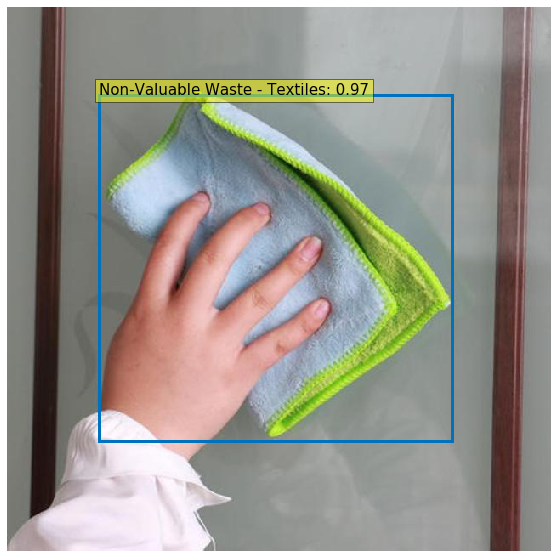

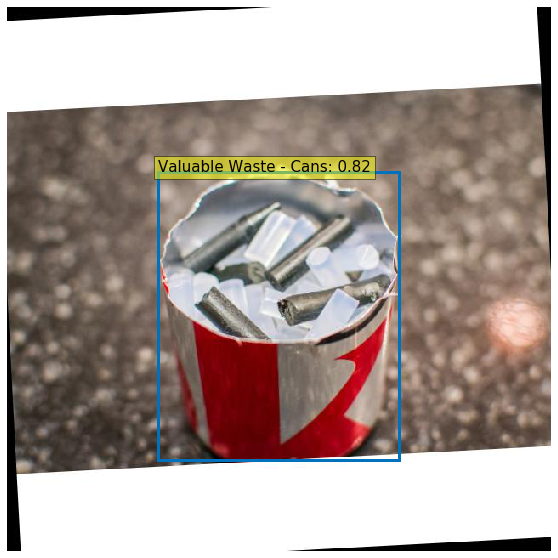

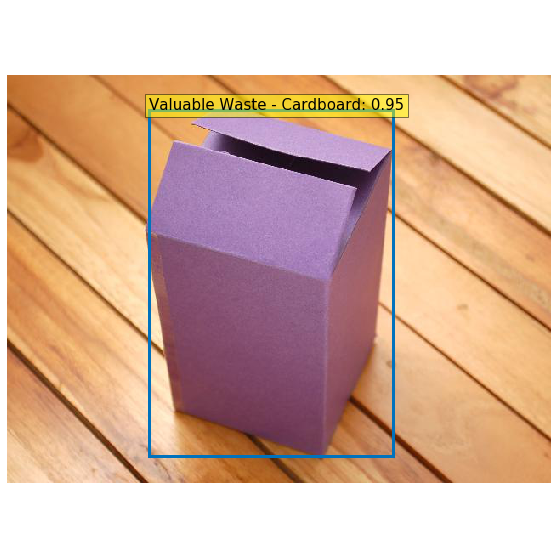

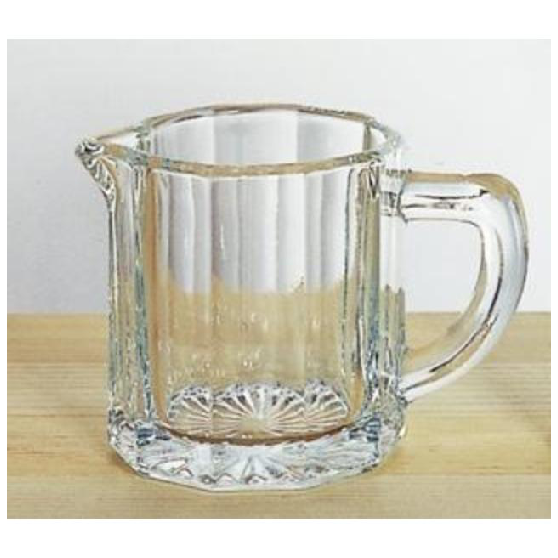

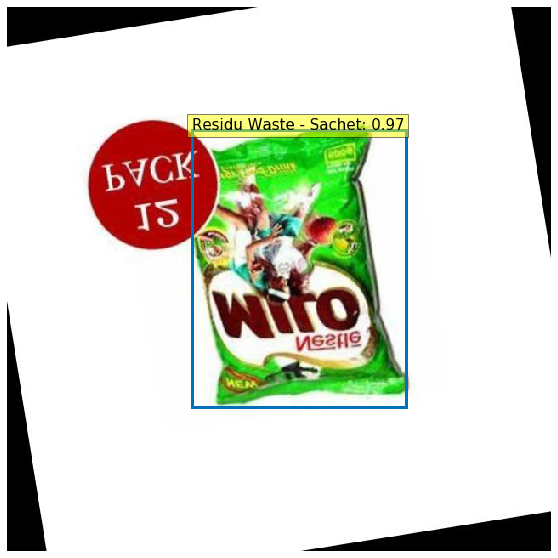

In [ ]:
# Inference on validation data
for i in np.random.randint(0, len(val), 5):
    pixel_values, target = val[i]
    pixel_values = pixel_values.unsqueeze(0)
    batch_size, num_channels, height, width = pixel_values.shape
    pixel_mask = torch.ones((batch_size, height, width), dtype=torch.bool)
    with torch.no_grad():
  # forward pass to get class logits and bounding boxes
      outputs = model(pixel_values=pixel_values, pixel_mask=pixel_mask)
    # load image based on ID
    image_id = target['image_id'].item()
    image = val.coco.loadImgs(image_id)[0]
    image = Image.open(os.path.join('trash_data/trash.v33-allclass.coco.zip (Unzipped Files)/train', image['file_name']))

    # postprocess model outputs
    width, height = image.size
    postprocessed_outputs = processor.post_process_object_detection(outputs,
                                                                    target_sizes=[(height, width)],
                                                                    threshold=0.75)
    results = postprocessed_outputs[0]
    plot_results(image, results['scores'], results['labels'], results['boxes'])

### Inference on test data

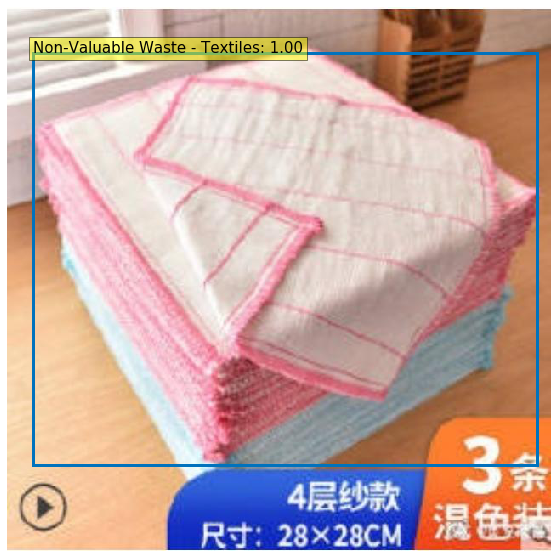

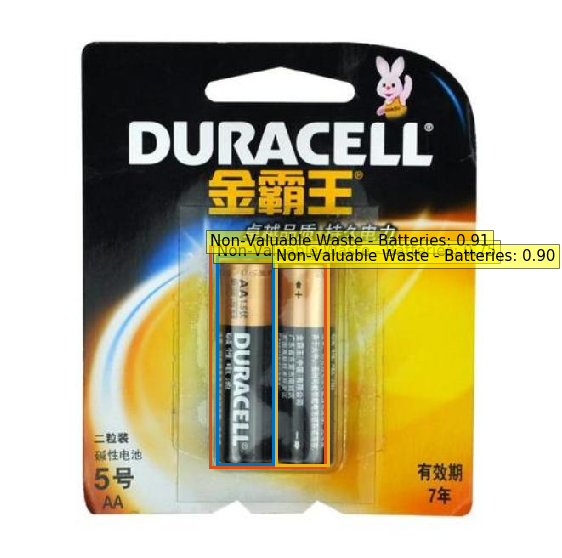

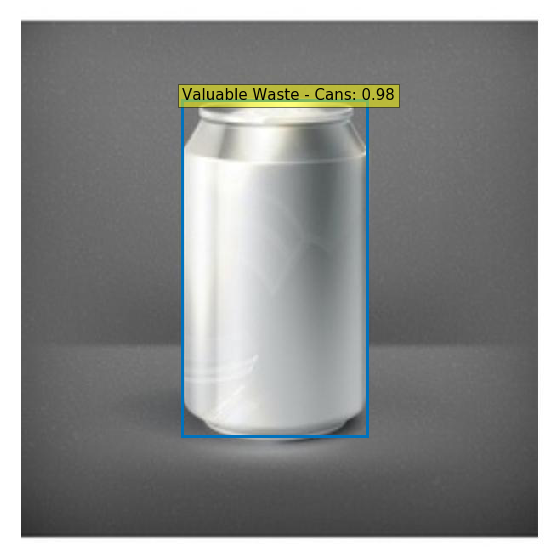

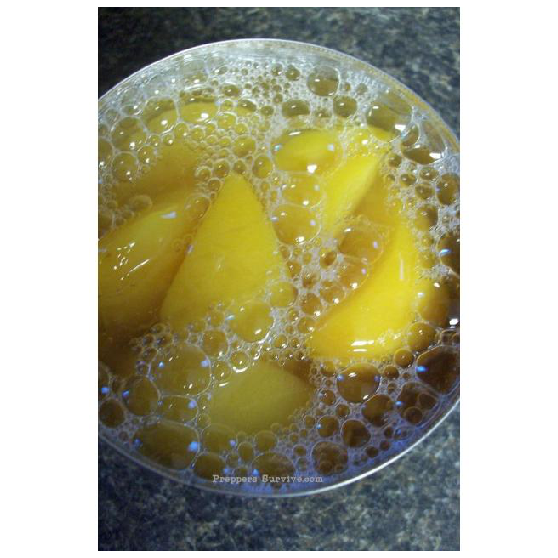

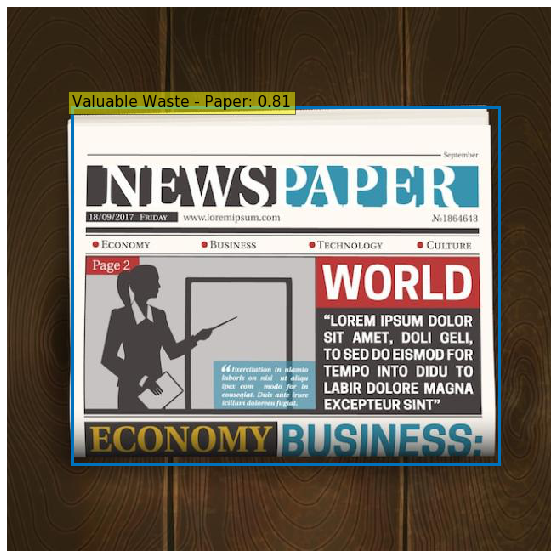

In [ ]:
# Inference on test data
for i in np.random.randint(0, len(test), 5):
    pixel_values, target = test[i]
    pixel_values = pixel_values.unsqueeze(0)
    batch_size, num_channels, height, width = pixel_values.shape
    pixel_mask = torch.ones((batch_size, height, width), dtype=torch.bool)
    with torch.no_grad():
  # forward pass to get class logits and bounding boxes
      outputs = model(pixel_values=pixel_values, pixel_mask=pixel_mask)
    # load image based on ID
    image_id = target['image_id'].item()
    image = test.coco.loadImgs(image_id)[0]
    image = Image.open(os.path.join('trash_data/trash.v33-allclass.coco.zip (Unzipped Files)/valid', image['file_name']))

    # postprocess model outputs
    width, height = image.size
    postprocessed_outputs = processor.post_process_object_detection(outputs,
                                                                    target_sizes=[(height, width)],
                                                                    threshold=0.75)
    results = postprocessed_outputs[0]
    plot_results(image, results['scores'], results['labels'], results['boxes'])